# 1. Importing of essential modules/libraries

In [25]:
import numpy as np
import librosa
import math
import re
import os
import sys
import time
import math
import tensorflow
from keras.models import Sequential, load_model
from keras.layers.recurrent import LSTM
from keras.layers import Dense, Dropout
from sklearn.preprocessing import LabelEncoder, StandardScaler
from keras.utils.np_utils import to_categorical
from keras.layers import MaxPooling2D,Conv2D,Flatten,Activation
from sklearn.model_selection import train_test_split
import IPython.display as ipd
from IPython.display import clear_output
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
from keras.layers import (Convolution1D, Dense, Dropout, GlobalAveragePooling1D, 
                          GlobalMaxPool1D, Input, MaxPool1D, concatenate)

# 2.Creating a library, which allows to extract features from files in directories

In [119]:
class AudioDataGenerator:
    
    """Function just for testing. Modify it for your own needs(mainly just path)"""
    def count_files(self, path):
        counter = 0
        for directory in os.listdir(path):
            for file in os.listdir(path + "\\" + directory):
                counter = counter + 1
        return counter
    def extract_feature(self,file_name):
        X, sample_rate = librosa.load(file_name,duration=5)
        stft = np.abs(librosa.stft(X))
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
        chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
        mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
        contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
        tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X),sr=sample_rate).T,axis=0)
        return mfccs,chroma,mel,contrast,tonnetz
    
    def flow_from_directory_alt(self, dir_path):
        labels = []
        X_train = []
        for directory in os.listdir(dir_path):
            for file in os.listdir(dir_path + "\\" + directory):
                features = []
                mfccs, chroma, mel, contrast,tonnetz = self.extract_feature(dir_path + "\\" + directory + "\\" + file)
                features.append(mfccs)
                features.append(chroma) 
                features.append(mel) 
                features.append(contrast)
                features.append(tonnetz) 
                X_train.append(features)
                labels.append(directory)
        return X_train, labels
    
    def flow_from_directory(self,dir_path):
        file_number = self.count_files(dir_path)
        print("Found {} files".format(file_number))
        
        """All parameters needed for the future"""
        
        labels = []
        data = []
        counter = 0
        cat_counter = 0
        timeseries_length = 32
        hop_length = 256
        percentage_counter = 1
        step_counter = 1
        data = np.zeros((file_number, timeseries_length, 50), dtype=np.float64)
          
        start_time = time.time()
        
        for directory in os.listdir(dir_path):
            category = directory
            cat_counter = cat_counter + 1
            for file in os.listdir(dir_path +"\\"+category):
                y, sr = librosa.load(dir_path + "\\" + category +"\\" + file)
                
                mfcc = librosa.feature.mfcc(y=y, sr=sr, hop_length= hop_length, n_mfcc= 50)
                mean = np.mean(mfcc, axis=0)
                std = np.std(mfcc, axis=0)
                mfcc = (mfcc - mean) / std
                
                data[counter, :, 0:50] = mfcc.T[0:timeseries_length, :]
                
                elapsed_time = time.time() - start_time
                
                counter = counter + 1 #represents the number of files that have been extracted
                
                labels.append(category)
                percentage = counter / file_number
                
                current_step = file_number * 0.05 * step_counter
                files_per_second = counter // elapsed_time
                
                remaining_files = file_number - counter
                remaining_time = remaining_files // files_per_second
                
        
                if counter >= current_step:
                    clear_output()
                    #print("{} - {}".format(counter, current_step)) #Helping line while coding
                    self.animate_extraction(percentage, files_per_second, remaining_time)
                    step_counter = step_counter + 1
        
        
        print("Extracted {} files from {} categories".format(counter, cat_counter ))
        return data, np.expand_dims(np.asarray(labels), axis=1)
       
    """Extracting features of a single file. To test&check how a current model is working"""  
    
    def test_sample(self, filename):
                timeseries_length = 32
                hop_length = 256
                data = np.zeros((1, timeseries_length, 50), dtype=np.float64)
            
                y, sr = librosa.load(os.getcwd() + "\\dataset_animals\\test\\"+ filename)
                mfcc = librosa.feature.mfcc(y=y, sr=sr, hop_length= hop_length, n_mfcc= 50)
                mean = np.mean(mfcc, axis=0)
                std = np.std(mfcc, axis=0)
                mfcc = (mfcc - mean) / std
                
                data[0, :, 0:50] = mfcc.T[0:timeseries_length, :]
                
                return data
            
    """A simple method to visualise the rate of extracting features.
        Not directly related to the meaning of the rest of the code."""
    
    def animate_extraction(self, percentage, files_per_second, remaining_time):
        sys.stdout.write("[")
        total_num_signs = 20 #Max number of hashes is 20. We refresh the bar every 5%
        hash_num = math.floor(percentage*total_num_signs) #Current number of hashes.
        
        for i in range(0, hash_num):
            sys.stdout.write("#")
        for i in range(0, total_num_signs - hash_num):
            sys.stdout.write("-")

        sys.stdout.write("] ")
        sys.stdout.write("{}% Average:{} files per second\n".format(int(percentage * 100), int(files_per_second)))
        if(remaining_time > 0):
            sys.stdout.write("Remaining time:{}\n\n".format(int(remaining_time)))

# 3.Preprocessing data & feature extraction

## 3.1 Using function to extract numpy arrays 

In [120]:
generator = AudioDataGenerator()
#generator.count_files() #info about the number of all files(except directories) in all directiories in our path

X_train, y_train = generator.flow_from_directory(os.getcwd() + "\\dataset_animals\\train") #Extraction features, got almost ready datasets

[####################] 100% Average:4 files per second
Extracted 210 files from 2 categories


In [121]:
X_valid, y_valid = generator.flow_from_directory(os.getcwd() + "\\dataset_animals\\test")

[####################] 100% Average:5 files per second
Extracted 67 files from 2 categories


In [122]:
lbl_enc = LabelEncoder()

y_train_enc = lbl_enc.fit_transform(y_train)
y_valid_enc = lbl_enc.transform(y_valid)

y_train_enc = np.ravel(y_train_enc)
y_valid_enc = np.ravel(y_valid_enc)

y_train_enc = to_categorical(y_train_enc, 2)
y_valid_enc = to_categorical(y_valid_enc, 2)

D:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [110]:
print(lbl_enc.classes_)

X_train.shape

['cat' 'dog']


# 4.Creating a model

# 4.1 The architecture of the model

In [123]:
model = Sequential()
model.add(LSTM(units= 256, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units= 128, return_sequences=False))
model.add(Dense(units = 16, activation = "relu"))
model.add(Dense(units = 8, activation = "relu"))
model.add(Dense(units = 4, activation = "relu"))
model.add(Dense(units= 2, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 32, 256)           314368    
_________________________________________________________________
lstm_9 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dense_50 (Dense)             (None, 16)                2064      
_________________________________________________________________
dense_51 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_52 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_53 (Dense)             (None, 2)                 10        
Total params: 513,734
Trainable params: 513,734
Non-trainable params: 0
_________________________________________________________________


# 4.2 Compilation

In [125]:
model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

# 5.Training process

In [ ]:
process_history = model.fit(
        X_train,
        y_train_enc,
        epochs = 5,
        steps_per_epoch = X_train.shape[0]// 8,
        validation_data = (X_valid, y_valid_enc),
        validation_steps =  X_train.shape[0] // 8
)

Train on 210 samples, validate on 67 samples
Epoch 1/5
26/26 [==============================] - 17s 650ms/step - loss: 0.3858 - acc: 0.8333 - val_loss: 0.3275 - val_acc: 0.8657
Epoch 2/5
26/26 [==============================] - 14s 552ms/step - loss: 0.1632 - acc: 0.9484 - val_loss: 0.4633 - val_acc: 0.8358
Epoch 3/5
26/26 [==============================] - 15s 581ms/step - loss: 0.1058 - acc: 0.9668 - val_loss: 0.5961 - val_acc: 0.8358
Epoch 4/5
16/26 [=================>............] - ETA: 5s - loss: 0.0378 - acc: 0.9926

# 6.Saving the trained model to a file

In [120]:
model.save("./model/dogs&cats.h5") # Optional [dogs / cats]

# 7. Loading from an external file

In [102]:
model = load_model("./model/dogs&cats.h5") # Optional

# 8. Testing section. Playground

### 8.1 Enter a filename. (If your filepath is different from the repo, change it directly in code)

In [121]:
generator = AudioDataGenerator()

test_sample = generator.test_sample("\\dog\\dog_barking_19.wav")

### 8.2 Predicting what out file plays

In [122]:
preds = model.predict(test_sample)

In [123]:
preds #printing out the results. 

array([[0.00354158, 0.6952108 ]], dtype=float32)

### 8.3 Play

In [126]:
ipd.Audio('./dataset_animals/test/dog/dog_barking_19.wav') # load a local WAV file

## 8.4 Visualisation

### 8.4.1 Raw data from a file. Time to Amplitude

In [127]:
x, sr = librosa.load('./dataset_animals/test/dog/dog_barking_19.wav') # extract features
#x, index = librosa.effects.trim(x) #trimming/getting rid of "0 amplitude areas"
#print(librosa.get_duration(x), librosa.get_duration(x))

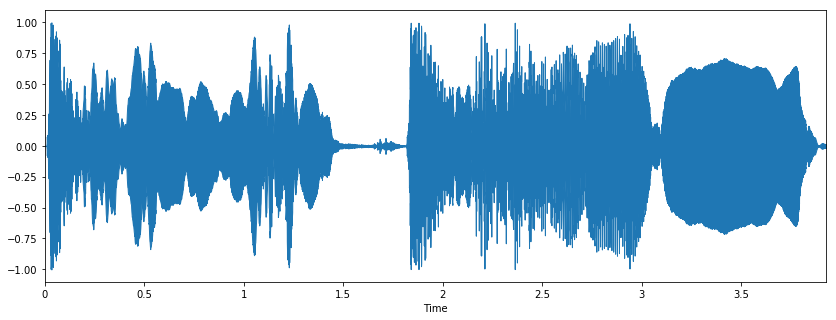

In [128]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)

### 8.4.2 Spectrogram

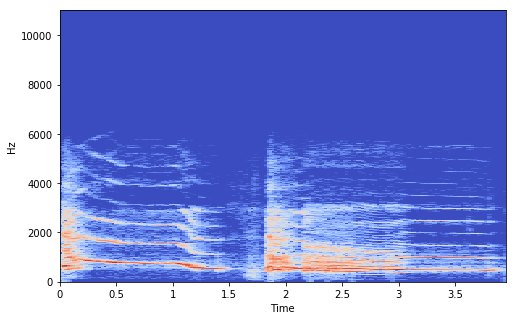

In [129]:
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(8, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')

# 9.Useful places in web to learn more

https://librosa.github.io/
https://musicinformationretrieval.com/